In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
from sklearn.model_selection import train_test_split
train_data_file = "train.csv"
test_data_file = "test.csv"

X = pd.read_csv(train_data_file, index_col='Id')
X_test = pd.read_csv(test_data_file, index_col='Id')

X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [ ]:
low_cardinality_columns = [col for col in X.columns if X[col].nunique() < 10 and X[col].dtype == "object"]
num_columns = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]

required_columns = low_cardinality_columns + num_columns
high_cardinality_columns = [col for col in X.columns if col not in required_columns]

print(required_columns)
print("Dropped_columns", high_cardinality_columns)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea

In [ ]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score


numerical_transformer = SimpleImputer(strategy="constant")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant")),
    ("one_hot_encoding", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_columns),
        ("categorical", categorical_transformer, low_cardinality_columns)
    ])

def get_scores(n_estimators, learning_rate):
    xgb_regressor_model = XGBRegressor(n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       random_state=0,
                                       n_jobs=4)

    model_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model_run", xgb_regressor_model)
    ])

    scores = -1 * cross_val_score(model_pipeline, X, y, cv=3, scoring="neg_mean_absolute_error")

    return scores.mean()

In [ ]:
results = {}

for i in range(8, 13):
    for j in range(3):
        results[(100*i, 0.04 + 0.01*j)] = get_scores(100*i, 0.04 + 0.01*j)

{(800, 0.04): 17138.572072355168, (800, 0.05): 17099.256445181018, (800, 0.06): 17248.515934542007, (900, 0.04): 17138.51688494258, (900, 0.05): 17096.35879145506, (900, 0.06): 17251.2428120414, (1000, 0.04): 17137.268818994213, (1000, 0.05): 17098.802937426324, (1000, 0.06): 17252.61062691053, (1100, 0.04): 17142.42384344641, (1100, 0.05): 17099.08982126576, (1100, 0.06): 17252.866172358903, (1200, 0.04): 17141.266039310747, (1200, 0.05): 17098.012448538768, (1200, 0.06): 17252.675407814688}


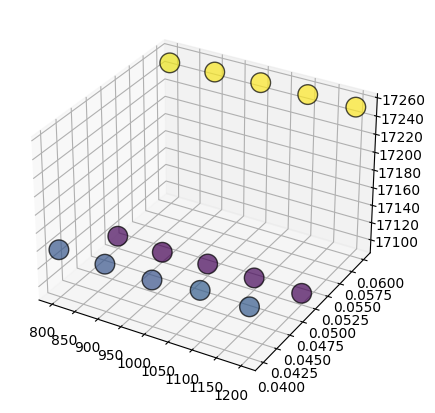

(900, 0.05) 17096.35879145506


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

print(results)

x_axis = list(each[0] for each in results)
y_axis = list(each[1] for each in results)
error = list(results[each] for each in results)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_axis, y_axis, error,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=error)
plt.show()

min_mae = math.inf
res = None
for each in results:
    if results[each] < min_mae:
        min_mae = results[each]
        res = each

print(res, min_mae)

In [ ]:
import pickle
xgb_regressor_model = XGBRegressor(n_estimators=res[0],
                                   learning_rate=res[1],
                                   random_state=0,
                                   n_jobs=4)

model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model_run", xgb_regressor_model)
])
model_pipeline.fit(X, y)
pickle.dump(model_pipeline, open("housing_price_model.pkl", "wb"))
preds = model_pipeline.predict(X_test)

In [ ]:
output = pd.DataFrame({"Id": X_test.index, "SalePrice": preds})
output.to_csv("submission.csv", index=False)

In [ ]:
output.head()

,Id,SalePrice
0,1461,122485.289062
1,1462,157573.562500
2,1463,185845.734375
3,1464,192050.500000
4,1465,201164.312500
